In [4]:
import mkl
mkl.set_num_threads(1)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

from firesong.Firesong import firesong_simulation
from firesong.FluxPDF import flux_pdf
import pandas as pd
from os.path import join
import seaborn as sns
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
Planck18.luminosity_distance(0.3365) # TXS 0506+056

<Quantity 1830.08071709 Mpc>

# flux references

In [5]:
from fluxes import ngc_flux, txs_flux

In [6]:
ngc_flux, txs_flux

(PL_flux(norm=5e-14, gamma=3.2, E0=1000.0, shape='powerlaw'),
 PL_flux(norm=2.7e-20, gamma=2.0, E0=100000.0, shape='powerlaw'))

1.9905358527674847e-10
2.7e-10
1.8e-08
1.892872033440579e-09
1e-08


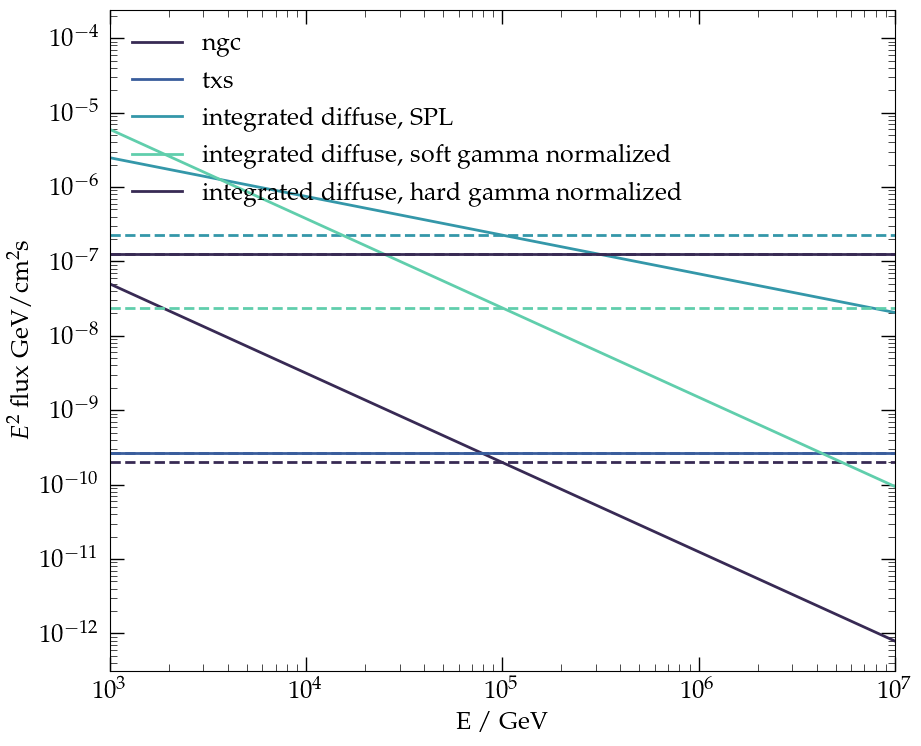

In [7]:
logE = np.linspace(2, 7)
E = 10**logE  # GeV

flux_ngc = (
    lambda energy: ngc_flux.norm * (energy / ngc_flux.E0) ** -ngc_flux.gamma
)  # / GeV cm^2 s
flux_txs = (
    lambda energy: txs_flux.norm * (energy / txs_flux.E0) ** -txs_flux.gamma
)  # / GeV cm^2 s
flux_diffuse = lambda energy: 1.8e-18 * (energy / 1e5) ** -2.52
flux_diffuse_soft = lambda energy: 3e-8 / (1e4**2) * (energy / 1e4) ** -3.2
flux_diffuse_hard = lambda energy: 1e-8 / (1e4**2) * (energy / 1e4) ** -2.0
_prefactor = 1  # 1E-3

E_ref = 1e5

norm_ngc = (E_ref**2) * flux_ngc(E_ref)
norm_txs = (E_ref**2) * flux_txs(E_ref)
norm_diffuse = (E_ref**2) * flux_diffuse(E_ref)
norm_diffuse_soft = (E_ref**2) * flux_diffuse_soft(E_ref)
norm_diffuse_hard = (E_ref**2) * flux_diffuse_hard(E_ref)

plt.figure(figsize=(10, 8))

p = plt.loglog(E, _prefactor * (E**2) * flux_ngc(E), label="ngc")
plt.axhline(norm_ngc, color=p[0].get_color(), ls="--")

p = plt.loglog(E, _prefactor * (E**2) * flux_txs(E), label="txs")
plt.axhline(norm_txs, color=p[0].get_color(), ls="--")

p = plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse(E) * 4 * np.pi,
    label="integrated diffuse, SPL",
)
plt.axhline(norm_diffuse * 4 * np.pi, color=p[0].get_color(), ls="--")

p = plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse_soft(E) * 4 * np.pi,
    label="integrated diffuse, soft gamma normalized",
)
plt.axhline(norm_diffuse_soft * 4 * np.pi, color=p[0].get_color(), ls="--")

p = plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse_hard(E) * 4 * np.pi,
    label="integrated diffuse, hard gamma normalized",
)
plt.axhline(norm_diffuse_hard * 4 * np.pi, color=p[0].get_color(), ls="--")


plt.grid()
plt.ylabel(r"$E^2$ flux  $ \rm GeV / cm^2 s $")
plt.xlabel(r"E / GeV")
plt.xlim(1e3, 1e7)
# plt.ylim(1e-14, 1.5e-9)
plt.legend(loc=2, bbox_to_anchor=(0, 1.0, 0, 0), frameon=False)


print(norm_ngc)
print(norm_txs)
print(norm_diffuse)
print(norm_diffuse_soft)
print(norm_diffuse_hard)

fluxnorm E^2 dPhi/dE = GeV s^-1 cm^-2 sr^-1 (default 1.44E-8)

total_flux: per steradian; flux per source: GeV s^-1 cm^-2

# load flux DP for NGC-like sources

In [8]:
BASEPATH = "/home/hpc/capn/capn102h/repos/Plenum"

In [9]:
ngc_flux_ps = pd.read_pickle(join("/home/hpc/capn/capn102h/repos/Plenum", "resources/flux_ngc_disc_pot.pickle"))
flux_agg = ngc_flux_ps.groupby("ident").aggregate({"disc5": ["min", "max", "mean"]})
flux_agg.columns = flux_agg.columns.droplevel()
flux_h = pd.DataFrame(ngc_flux_ps.groupby("ident").apply(
    lambda x: x.loc[np.isclose(x.dec, 0)]["disc5"]
))
flux_h.index = flux_h.index.droplevel(1)
flux_h.columns = ["horizon"]

flux_agg = pd.concat([flux_agg, flux_h], axis=1)

calc_E2norm = lambda E_ref, norm, gamma: (E_ref**2) * norm * (E_ref / ngc_flux.E0) ** -gamma

# simulate various PDFs

In [10]:
from itertools import product

## soft spectrum

In [31]:
## SC luminosity example
from firesong.Evolution import get_evolution, SourcePopulation, cosmology
Evolution = "MD2014SFR"
fluxnorm = norm_diffuse_hard
density = np.power(10, -7.0)
emin = 100
emax = 1e7
zmax = 10.0
index = ngc_flux.gamma

population = SourcePopulation(cosmology, get_evolution(Evolution))
luminosity = population.StandardCandleLuminosity(
    fluxnorm, density, zmax, index, emin=emin, emax=emax
)
luminosity

5.246490272417139e+53

In [48]:
simPDF_ngc = {}
_lumi_kw = dict(
    index=ngc_flux.gamma,
    emin=100,
    emax=1e7,
    zmax=10.0,
)
_kw = dict(
    outputdir=None,
    filename=None,
    Evolution="MD2014SFR",
    logFMin=-35,
    logFMax=0,
    LumMin=1e30,
    LumMax=1e60,
    verbose=False,
    with_dFdz=True,
    # nFluxBins=150,
)
_list = []
_redshift = []
# densities = np.round(np.arange(5.0, 11.1, step=1), decimals=1)
# for indx, _width, _fluxref in product(densities, [1], [1, 0.1]):
#     # print(indx)
for _fluxref in [1, 0.1]:
    if _fluxref == 1:
        densities = np.arange(6, 8, step=1)  # 5
    else:
        densities = np.arange(10, 12, step=1)  # 9
    for indx in densities:
        if indx == 5:
            nFluxBins = 50
        else:
            nFluxBins = 150

        fluxnorm = norm_diffuse_soft * _fluxref
        density = np.power(10, -indx * 1.0)
        _tmp = flux_pdf(
            density=density,
            LF="SC",  # "LG",
            # sigma=_width,
            fluxnorm=fluxnorm,
            nFluxBins=nFluxBins,
            **_kw,
            **_lumi_kw,
        )
        population = SourcePopulation(cosmology, get_evolution(_kw["Evolution"]))
        luminosity = population.StandardCandleLuminosity(fluxnorm, density, **_lumi_kw)
        _list.append(
            pd.DataFrame(
                {
                    "Source number density": rf"$10^{{{-indx}}}$ " + r"Mpc$^{-3}$",
                    "Source number density numeric": indx,
                    "width": "SC",
                    "Fraction of total flux": _fluxref,
                    "E2flux": _tmp[0][::-1],
                    "Nsrc": _tmp[1][::-1],
                    "luminosity": luminosity,
                }
            )
        )
        _redshift.append(
            pd.DataFrame(
                {
                    "Source number density numeric": indx,
                    "Fraction of total flux": _fluxref,
                    "luminosity": luminosity,
                    "redshift z": _tmp[2],
                    "Flux from redshift z": _tmp[3],
                }
            )
        )
df_soft = pd.concat(_list)
redshift_soft = pd.concat(_redshift)
df_soft["cumulative_Nsrc"] = (
    df_soft.groupby(["Source number density", "width", "Fraction of total flux"])
    .cumsum()
    .Nsrc
)
# convert E^2 flux at 100 TeV to flux at 1 TeV
df_soft["log_flux"] = df_soft["E2flux"] - 10 + np.log10(100**3.2)
df_soft["flux"] = np.power(10, df_soft["log_flux"])

In [35]:
df_soft.to_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/resources/source_population_softgamma.csv"
)

In [52]:
redshift_soft

,Source number density numeric,Fraction of total flux,luminosity,redshift z,Flux from redshift z
0,6,1.0,9.930935e+51,0.0005,2.970156e-12
1,6,1.0,9.930935e+51,0.0015,2.546734e-10
2,6,1.0,9.930935e+51,0.0025,5.975233e-10
3,6,1.0,9.930935e+51,0.0035,1.373085e-10
4,6,1.0,9.930935e+51,0.0045,8.255968e-11
...,...,...,...,...,...
9995,11,0.1,9.930935e+55,9.9960,2.165954e-17
9996,11,0.1,9.930935e+55,9.9970,2.164459e-17
9997,11,0.1,9.930935e+55,9.9980,2.162965e-17
9998,11,0.1,9.930935e+55,9.9990,2.161472e-17


(0.0003, 0.01)

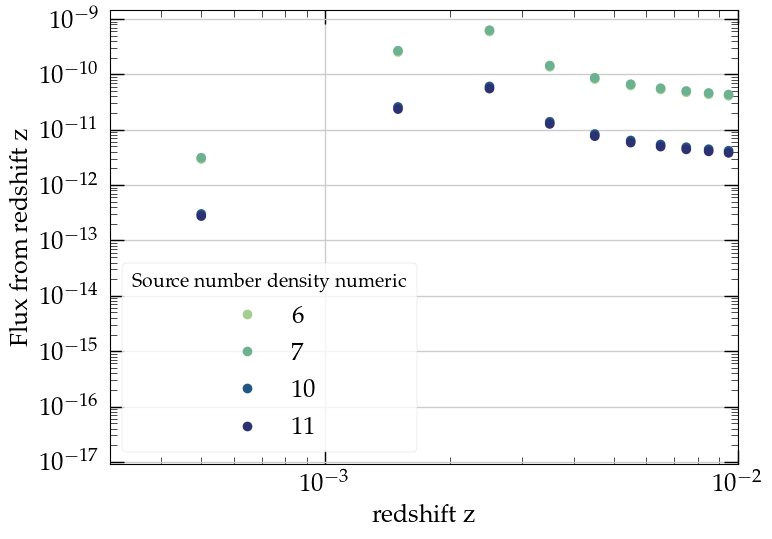

In [65]:
ax = sns.scatterplot(
    redshift_soft,
    x="redshift z",
    y="Flux from redshift z",
    hue="Source number density numeric",
    # style="Fraction of total flux",
    palette="crest",
    edgecolor="None",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(3E-4, 1E-2)

In [51]:
Planck18.luminosity_distance(redshift_soft["redshift z"])

<Quantity [2.21628251e+00, 6.65416105e+00, 1.10988226e+01, ...,
           1.05975082e+05, 1.05987109e+05, 1.05999136e+05] Mpc>

In [36]:
df_soft

,Source number density,Source number density numeric,width,Fraction of total flux,E2flux,Nsrc,luminosity,cumulative_Nsrc,log_flux,flux
0,$10^{-6}$ Mpc$^{-3}$,6,SC,1.0,0.000000,0.0,9.930935e+51,0.000000,-3.600000,2.511886e-04
1,$10^{-6}$ Mpc$^{-3}$,6,SC,1.0,-0.234899,0.0,9.930935e+51,0.000000,-3.834899,1.462516e-04
2,$10^{-6}$ Mpc$^{-3}$,6,SC,1.0,-0.469799,0.0,9.930935e+51,0.000000,-4.069799,8.515327e-05
3,$10^{-6}$ Mpc$^{-3}$,6,SC,1.0,-0.704698,0.0,9.930935e+51,0.000000,-4.304698,4.957949e-05
4,$10^{-6}$ Mpc$^{-3}$,6,SC,1.0,-0.939597,0.0,9.930935e+51,0.000000,-4.539597,2.886707e-05
...,...,...,...,...,...,...,...,...,...,...
145,$10^{-11}$ Mpc$^{-3}$,11,SC,0.1,-34.060403,0.0,9.930935e+55,132.937684,-37.660403,2.185734e-38
146,$10^{-11}$ Mpc$^{-3}$,11,SC,0.1,-34.295302,0.0,9.930935e+55,132.937684,-37.895302,1.272618e-38
147,$10^{-11}$ Mpc$^{-3}$,11,SC,0.1,-34.530201,0.0,9.930935e+55,132.937684,-38.130201,7.409666e-39
148,$10^{-11}$ Mpc$^{-3}$,11,SC,0.1,-34.765101,0.0,9.930935e+55,132.937684,-38.365101,4.314191e-39


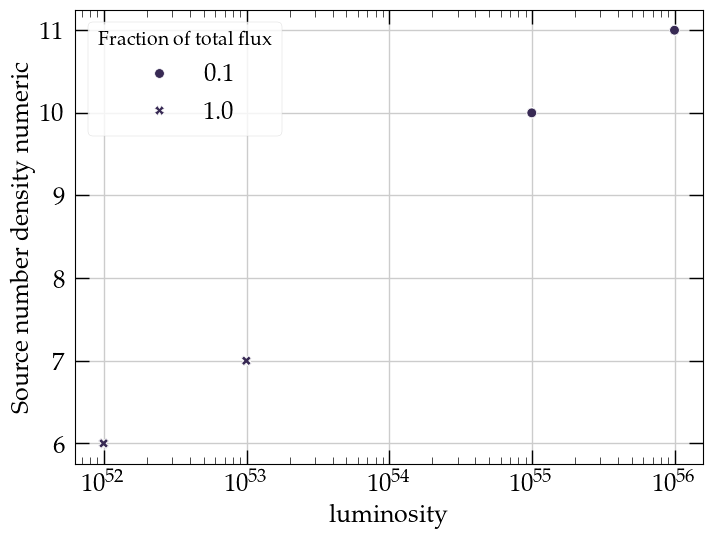

In [ ]:
ax = sns.scatterplot(
    df_soft,
    x="luminosity",
    y="Source number density numeric",
    style="Fraction of total flux",
)
ax.set_xscale("log")

## hard spectrum

In [19]:
simPDF_txs = {}
_kw = dict(
    outputdir=None,
    filename=None,
    index=txs_flux.gamma,
    Evolution="MD2014SFR",
    logFMin=-35,
    logFMax=0,
    emin=100,
    LumMin=1e30,
    LumMax=1e60,
    verbose=False,
    with_dFdz=True,
    # nFluxBins=150,
)
_list = []
# densities = np.round(np.arange(5.0, 11.1, step=1), decimals=1)
# for indx, _width, _fluxref in product(densities, [1], [1, 0.1]):
#     # print(indx)
for _fluxref in [1, 0.1]:
    if _fluxref == 1:
        densities = np.arange(5, 8, step=1) 
    else:
        densities = np.arange(8, 12, step=1) 
    for indx in densities:
        if indx == 5:
            nFluxBins = 50
        else:
            nFluxBins = 150
        _tmp = flux_pdf(
            density=np.power(10, -indx * 1.0),
            LF="SC",  # "LG",
            # sigma=_width,
            fluxnorm=norm_diffuse_hard * _fluxref,
            nFluxBins=nFluxBins,
            **_kw,
        )
        _list.append(
            pd.DataFrame(
                {
                    "Source number density": rf"$10^{{{-indx}}}$ "+r"Mpc$^{-3}$",
                    "width": "SC",
                    "Fraction of total flux": _fluxref,
                    "E2flux": _tmp[0][::-1],
                    "Nsrc": _tmp[1][::-1],
                }
            )
        )
df_hard = pd.concat(_list)
df_hard["cumulative_Nsrc"] = (
    df_hard.groupby(["Source number density", "width", "Fraction of total flux"])
    .cumsum()
    .Nsrc
)
# convert E^2 flux at 100 TeV to flux at 1 TeV 
df_hard["log_flux"] = df_hard["E2flux"] - 10 + np.log10(100**3.2)
df_hard["flux"] = np.power(10, df_hard["log_flux"])

In [14]:
df_hard.to_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/resources/source_population_hardgamma.csv"
)

# plots

In [15]:
cmap = sns.color_palette(
    np.concatenate(
        [sns.color_palette("crest", n_colors=3), sns.color_palette("magma", n_colors=3)]
    )
)

### for txs

Text(0, 0.5, '$N_{\\rm src} > \\log_{10}(\\Phi)$')

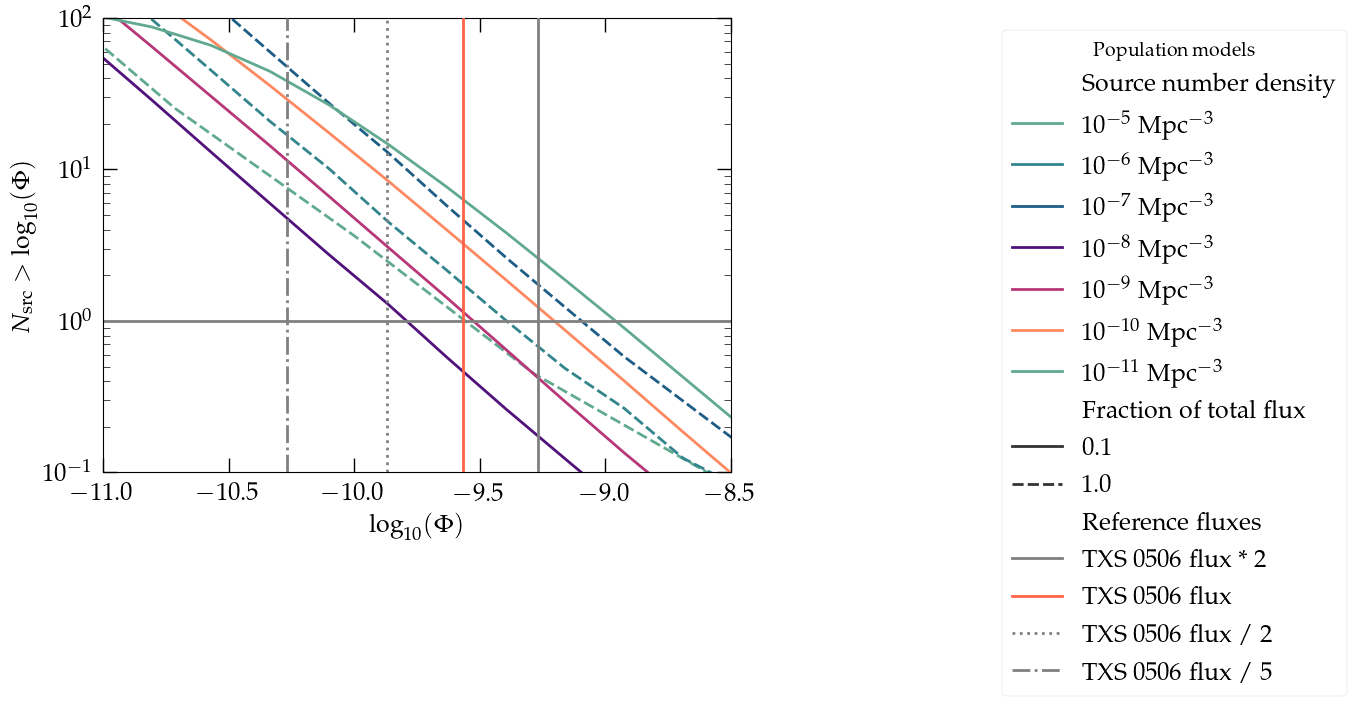

In [21]:
ax = sns.lineplot(
    data=df_hard,
    x="E2flux",
    y="cumulative_Nsrc",
    hue="Source number density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)

# plt.axvspan(
#     np.log10(norm_ngc / (5 / 3.5)),
#     np.log10(norm_ngc / (5 / 6.5)),
#     alpha=0.5,
#     color="gray",
# )
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")
# plt.axvline(
#     np.log10(norm_diffuse_soft * 4 * np.pi),
#     color="Gray",
#     ls=":",
#     label="Equiv. total diffuse flux",
# )
plt.axvline(
    np.log10(norm_txs * 2),
    ls="-",
    color="gray",
    label="TXS 0506 flux * 2",
    zorder=100,
)
plt.axvline(
    np.log10(norm_txs),
    ls="-",
    color="tomato",
    label="TXS 0506 flux",
    zorder=100,
)
plt.axvline(
    np.log10(norm_txs / 2),
    ls=":",
    color="gray",
    label="TXS 0506 flux / 2",
    zorder=100,
)
plt.axvline(
    np.log10(norm_txs / 5),
    ls="-.",
    color="gray",
    label="TXS 0506 flux / 5",
    zorder=100,
)
# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 1, 1), title="Population models")


plt.xlim(-11, -8.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="Gray")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")

In [ ]:
norm_txs

2.7e-10

### for ngc flux

In [23]:
df_soft

,Source number density,width,Fraction of total flux,E2flux,Nsrc,cumulative_Nsrc,log_flux,flux
0,$10^{-6}$ Mpc$^{-3}$,SC,1.0,0.000000,0.0,0.000000,-3.600000,2.511886e-04
1,$10^{-6}$ Mpc$^{-3}$,SC,1.0,-0.234899,0.0,0.000000,-3.834899,1.462516e-04
2,$10^{-6}$ Mpc$^{-3}$,SC,1.0,-0.469799,0.0,0.000000,-4.069799,8.515327e-05
3,$10^{-6}$ Mpc$^{-3}$,SC,1.0,-0.704698,0.0,0.000000,-4.304698,4.957949e-05
4,$10^{-6}$ Mpc$^{-3}$,SC,1.0,-0.939597,0.0,0.000000,-4.539597,2.886707e-05
...,...,...,...,...,...,...,...,...
145,$10^{-11}$ Mpc$^{-3}$,SC,0.1,-34.060403,0.0,132.937684,-37.660403,2.185734e-38
146,$10^{-11}$ Mpc$^{-3}$,SC,0.1,-34.295302,0.0,132.937684,-37.895302,1.272618e-38
147,$10^{-11}$ Mpc$^{-3}$,SC,0.1,-34.530201,0.0,132.937684,-38.130201,7.409666e-39
148,$10^{-11}$ Mpc$^{-3}$,SC,0.1,-34.765101,0.0,132.937684,-38.365101,4.314191e-39


Text(0, 0.5, '$N_{\\rm src} > \\log_{10}(\\Phi)$')

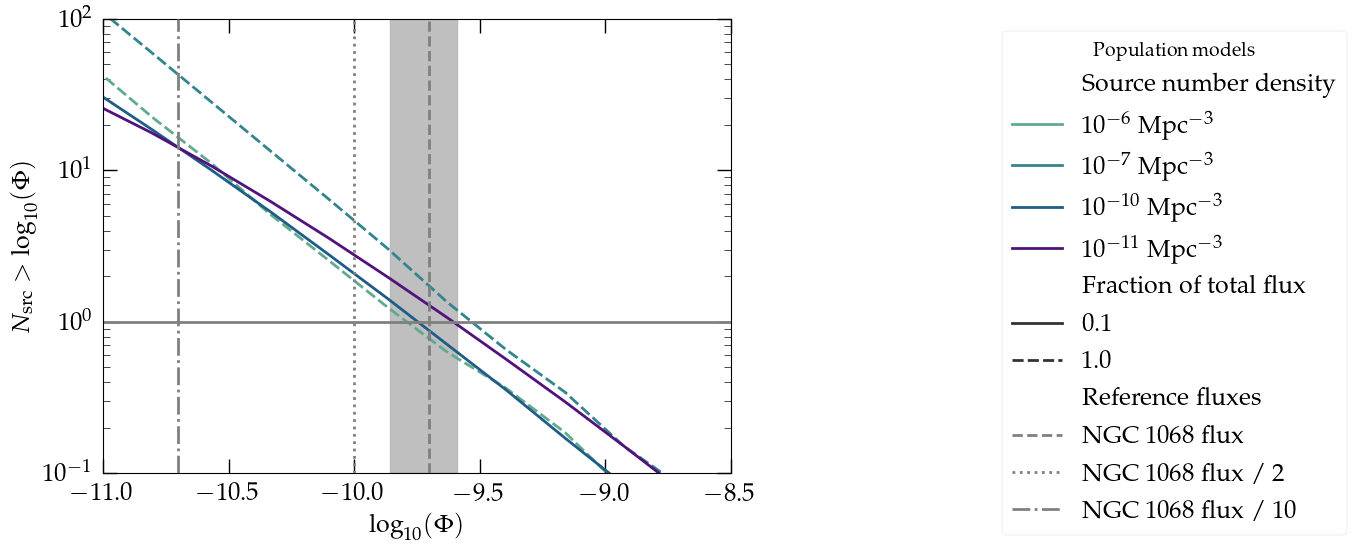

In [22]:
ax = sns.lineplot(
    data=df_soft,
    x="E2flux",
    y="cumulative_Nsrc",
    hue="Source number density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)

plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="gray",
)
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")
# plt.axvline(
#     np.log10(norm_diffuse_soft * 4 * np.pi),
#     color="Gray",
#     ls=":",
#     label="Equiv. total diffuse flux",
# )
plt.axvline(
    np.log10(norm_ngc),
    ls="--",
    color="gray",
    label="NGC 1068 flux",
    zorder=100,
)
plt.axvline(
    np.log10(norm_ngc / 2),
    ls=":",
    color="gray",
    label="NGC 1068 flux / 2",
    zorder=100,
)
plt.axvline(
    np.log10(norm_ngc / 10),
    ls="-.",
    color="gray",
    label="NGC 1068 flux / 10",
    zorder=100,
)
# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 1, 1), title="Population models")


plt.xlim(-11, -8.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="Gray")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")

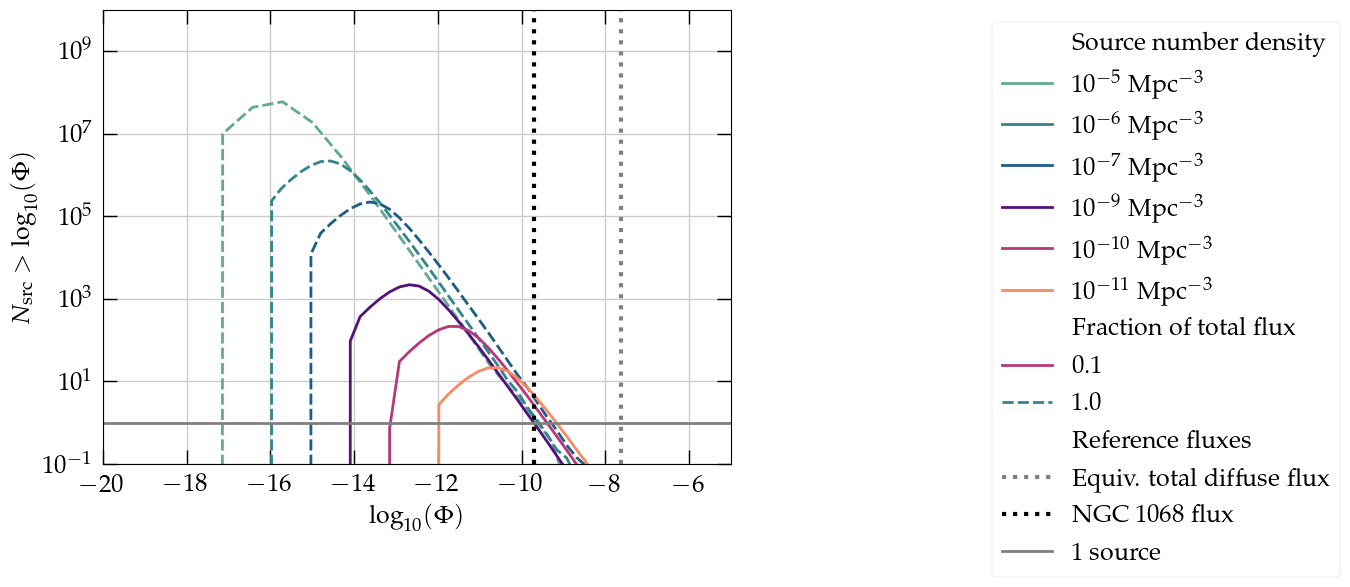

In [19]:
ax = sns.lineplot(
    data=df,
    x="E2flux",
    y="Nsrc",
    hue="Source number density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)
# just for legend
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="Gray",
    ls=":",
    label="Equiv. total diffuse flux",
    lw=3,
)
plt.axvline(
    np.log10(norm_ngc), ls=":", color="k", label="NGC 1068 flux", zorder=100, lw=3
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="Gray", label="1 source")
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")
lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.99, 1))
lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

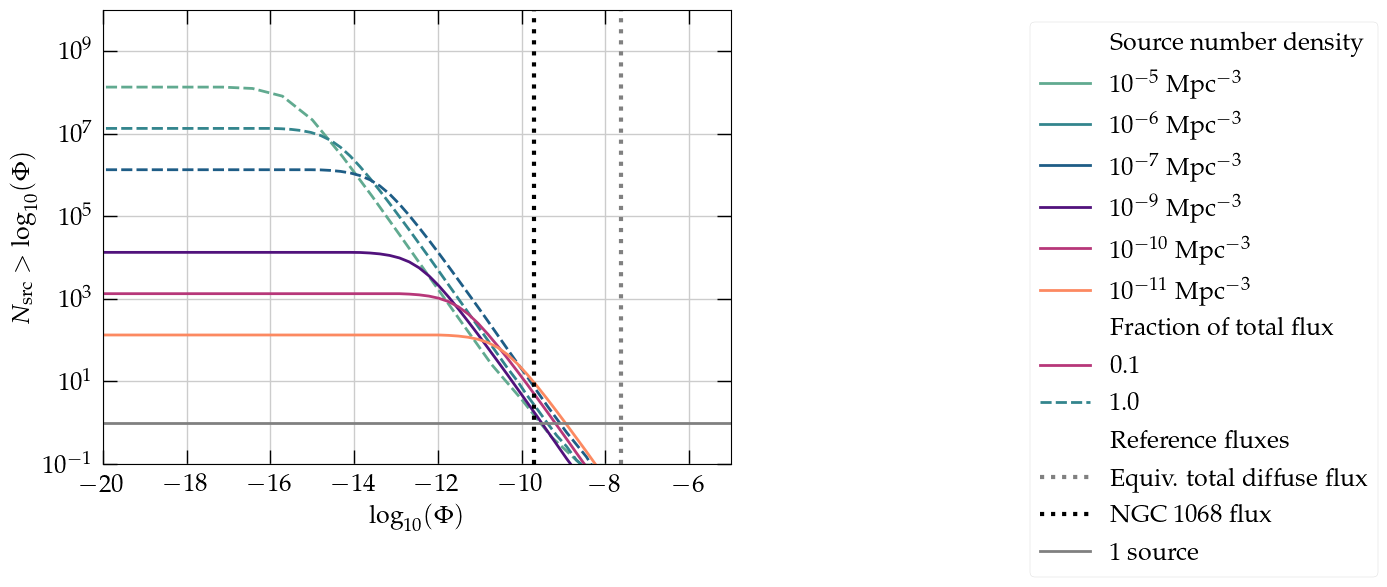

In [20]:
ax = sns.lineplot(
    data=df,
    x="E2flux",
    y="cumulative_Nsrc",
    hue="Source number density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)
# just for legend
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="Gray",
    ls=":",
    label="Equiv. total diffuse flux",
    lw=3,
)
plt.axvline(
    np.log10(norm_ngc), ls=":", color="k", label="NGC 1068 flux", zorder=100, lw=3
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="Gray", label="1 source")
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")
lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 1.05, 1))
lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

## combined plot

In [112]:
cmap = sns.color_palette(
    np.concatenate(
        [sns.color_palette("crest", n_colors=2), sns.color_palette("magma", n_colors=2)]
    )
)

Text(-11.143668881258241, 10000000.0, 'Total diffuse flux at 10 TeV\n{\\it ICRC} 2023')

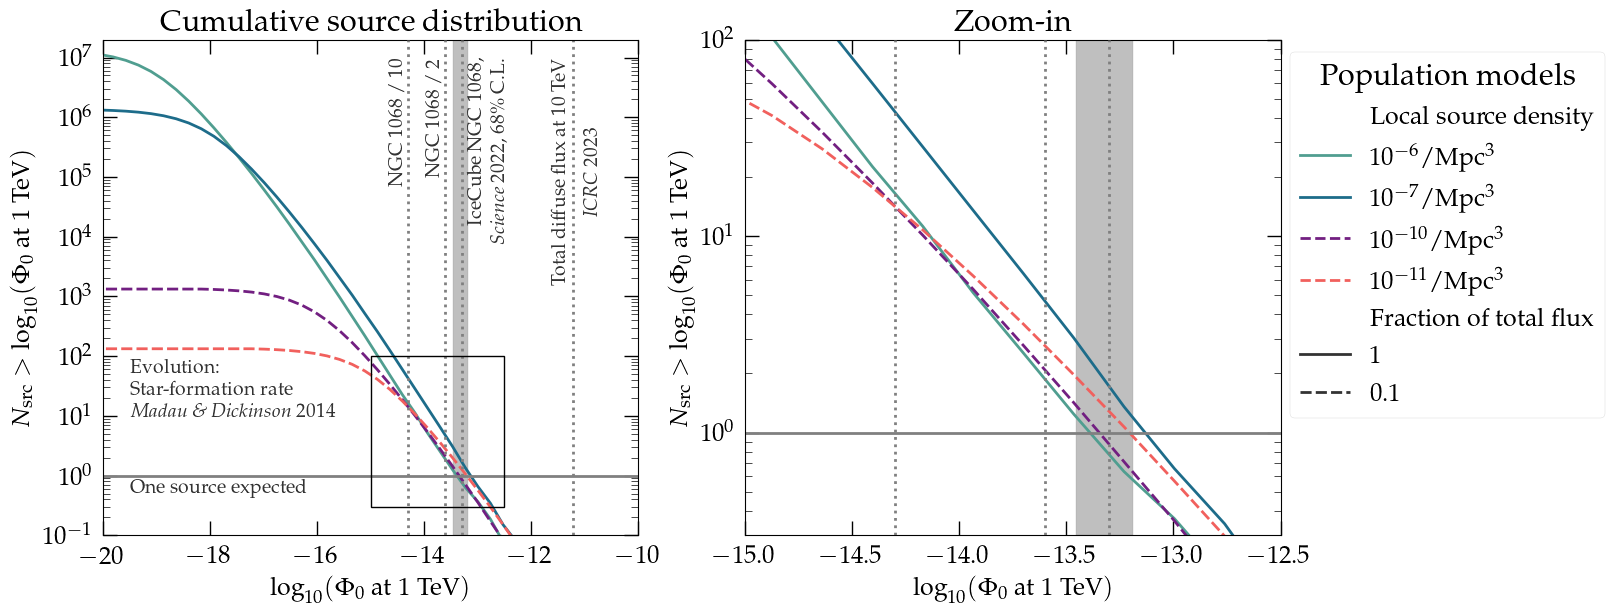

In [ ]:
## flux at 1 TeV
f, axes = plt.subplots(ncols=2, figsize=(15, 6), gridspec_kw=dict(wspace=0.2))
for ii, ax in enumerate(axes):
    ax = sns.lineplot(
        data=df,
        x="flux",
        y="cumulative_Nsrc",
        hue="Local source density",
        # size="width",
        style="Fraction of total flux",
        style_order=[1, 0.1],
        palette=cmap,  # "crest",
        ax=ax,
        legend=None if ii == 0 else "auto",
    )
    ax.axhline(1, color="Gray")

    ax.axvspan(
        np.log10(flux_ngc(ngc_flux.E0) / (5 / 3.5)),  # 5 +- 1.5
        np.log10(flux_ngc(ngc_flux.E0) / (5 / 6.5)),  # 5 +- 1.5
        alpha=0.5,
        color="gray",
    )
    # ax.plot(np.nan, np.nan, label="Reference fluxes", color="w")

    ax.axvline(
        np.log10(flux_ngc(ngc_flux.E0)),
        ls=":",
        color="gray",
        zorder=100,
    )
    ax.axvline(
        np.log10(flux_ngc(ngc_flux.E0) / 2),
        ls=":",
        color="gray",
        zorder=100,
    )
    ax.axvline(
        np.log10(flux_ngc(ngc_flux.E0) / 10),
        ls=":",
        color="gray",
        zorder=100,
    )
    ax.set_xlabel(r"$\log_{10}(\Phi_0 $ at 1 TeV$)$")
    ax.set_ylabel(r"$N_{\rm src} > \log_{10}(\Phi_0 $ at 1 TeV$)$")
    ax.set_yscale("log")
    ax.grid(False)

font_color = "0.2"
# zoom in
_xlim = (-15, -12.5)
_ylim = (3e-1, 100)
ax = axes[1]
lg = plt.legend(
    loc=1, bbox_to_anchor=(0.63, 0, 1, 1), title="Population models", title_fontsize=22
)
lg.legend_handles[3].set_linestyle("--")
lg.legend_handles[4].set_linestyle("--")
# ax.set_ylabel("")
ax.set_xlim(*_xlim)
ax.set_ylim(*_ylim)
ax.set_title("Zoom-in", fontsize=22)

# full view
ax = axes[0]
ax.axvline(
    np.log10(flux_diffuse_soft(ngc_flux.E0) * 4 * np.pi),
    color="Gray",
    ls=":",
)
_rect = mpl.patches.Rectangle(
    (_xlim[0], _ylim[0]),
    _xlim[1] - _xlim[0],
    _ylim[1] - _ylim[0],
    linewidth=1,
    edgecolor="k",
    facecolor="none",
    zorder=100,
)
ax.add_patch(_rect)
ax.set_xlim(-20, -10)
ax.set_ylim(1e-1, 2e7)
ax.set_title("Cumulative source distribution", fontsize=22)

ax.text(-19.5, 0.9, "One source expected", color=font_color, va="top")
ax.text(
    -19.5,
    90,
    "Evolution:"
    + "\n"
    + "Star-formation rate"
    + "\n"
    + r"{\it Madau \& Dickinson} 2014",
    color=font_color,
    va="top",
)

_toptext = 1e7
ax.text(
    np.log10(flux_ngc(ngc_flux.E0) / 10),
    _toptext,
    "NGC 1068 / 10",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)
ax.text(
    np.log10(flux_ngc(ngc_flux.E0) / 2),
    _toptext,
    "NGC 1068 / 2",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)

ax.text(
    np.log10(flux_ngc(ngc_flux.E0)) + 0.9,
    _toptext,
    r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)

ax.text(
    np.log10(flux_diffuse_soft(ngc_flux.E0) * 4 * np.pi)+0.08,
    _toptext,
    r"Total diffuse flux at 10 TeV" + "\n" + r"{\it ICRC} 2023",
    linespacing=1.8,
    color=font_color,
    rotation=90,
    ha="center",
    va="top",
)

# f.savefig(
#     join(st.BASEPATH, plot_path, "ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
# )

## E^2 flux - old


In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(15, 6), gridspec_kw=dict(wspace=0.2))
for ii, ax in enumerate(axes):
    ax = sns.lineplot(
        data=df,
        x="E2flux",
        y="cumulative_Nsrc",
        hue="Local source density",
        # size="width",
        style="Fraction of total flux",
        palette=cmap,
        ax=ax,
        legend=None if ii == 0 else "auto",
    )
    ax.axhline(1, color="Gray", label="1 source")

    ax.axvspan(
        np.log10(norm_ngc / (5 / 3.5)),  # based on 5 +- 1.5
        np.log10(norm_ngc / (5 / 6.5)),  # based on 5 +- 1.5
        alpha=0.5,
        color="gray",
    )
    ax.plot(np.nan, np.nan, label="Reference fluxes", color="w")

    ax.axvline(
        np.log10(norm_ngc),
        ls=":",
        color="gray",
        label="NGC 1068 flux",
        zorder=100,
    )
    ax.axvline(
        np.log10(norm_ngc / 2),
        ls=":",
        color="gray",
        label="NGC 1068 flux / 2",
        zorder=100,
    )
    ax.axvline(
        np.log10(norm_ngc / 10),
        ls=":",
        color="gray",
        label="NGC 1068 flux / 10",
        zorder=100,
    )
    # TODO convert E^2 \Phi_0 at 100 TeV to regular flux units used in paper
    ax.set_xlabel(
        r"$\log_{10}(E^2 \Phi_0$ at 100 TeV$)$"
    )  ### CHECK!! E^2 Phi_0 at 100 TeV?
    ax.set_ylabel(r"$N_{\rm src} > \log_{10}(E^2 \Phi_0$ at 100 TeV$)$")
    ax.set_yscale("log")
    ax.grid(False)

font_color = "0.2"
# zoom in
_xlim = (-11, -9)
_ylim = (3e-1, 100)
ax = axes[1]
lg = plt.legend(loc=1, bbox_to_anchor=(0.63, 0, 1, 1), title="Population models")
lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
ax.set_ylabel("")
ax.set_xlim(*_xlim)
ax.set_ylim(*_ylim)
ax.set_title("Zoom-in", fontsize=22)

# full view
ax = axes[0]
ax.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="Gray",
    ls=":",
    label="Equiv. total diffuse flux",
)
_rect = mpl.patches.Rectangle(
    (_xlim[0], _ylim[0]),
    _xlim[1] - _xlim[0],
    _ylim[1] - _ylim[0],
    linewidth=1,
    edgecolor="k",
    facecolor="none",
    zorder=100,
)
ax.add_patch(_rect)
ax.set_xlim(-17, -6.5)
ax.set_ylim(1e-1, 1e9)
ax.set_title("Cumulative source distribution", fontsize=22)

ax.text(-16.5, 1.2, "One source expected", color=font_color)

ax.text(
    np.log10(norm_ngc / 10),
    5e8,
    "NGC 1068 / 10",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)
ax.text(
    np.log10(norm_ngc / 2),
    5e8,
    "NGC 1068 / 2",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)

ax.text(
    np.log10(norm_ngc) + 1.1,
    5e8,
    r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
    color=font_color,
    rotation=90,
    ha="right",
    va="top",
)

ax.text(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    5e8,
    "Equiv. total diffuse flux" + "\n" + r"{\it ICRC} 2023",
    linespacing=1.5,
    color=font_color,
    rotation=90,
    ha="center",
    va="top",
)

## estimate poisson probability for 1 source

In [11]:
from scipy.stats import poisson

In [12]:
poisson.pmf(1, 0.4)

0.2681280184142557

0.4 0.0007150080491046819
1 0.015328310048810103
2 0.09022352215774178
3 0.16803135574154085
4 0.1953668148131645


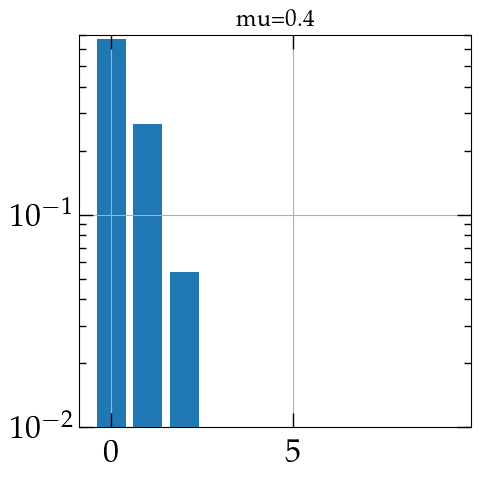

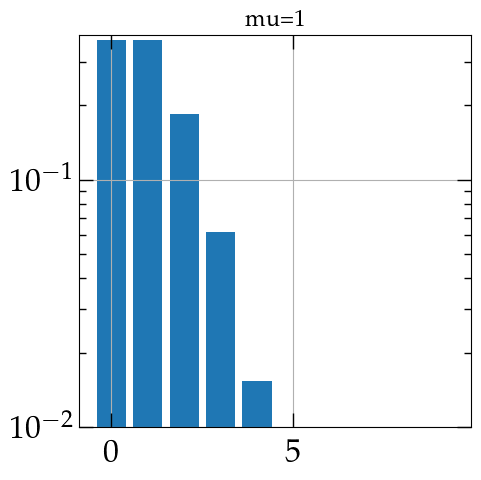

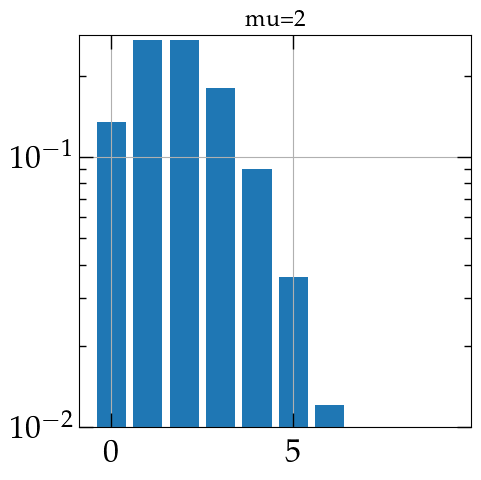

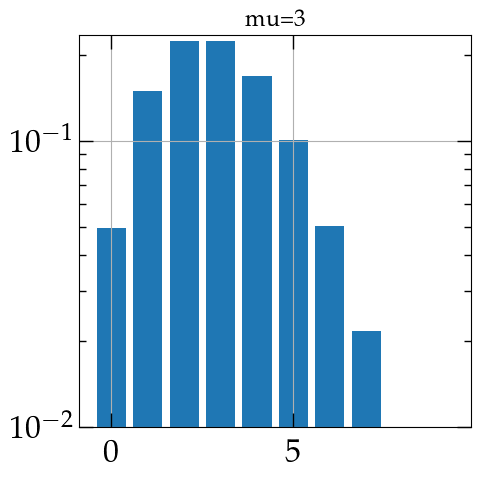

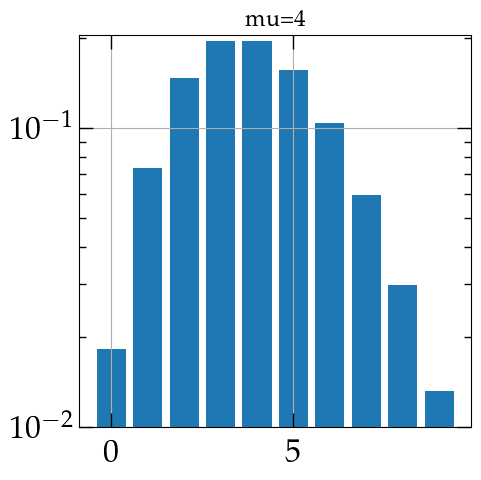

In [13]:
nums = np.arange(10)
for i in [0.4, 1, 2, 3, 4]:
    plt.figure()
    plt.title(f"mu={i}")
    plt.bar(nums, poisson.pmf(nums, i))
    print(i, poisson.pmf(4, i))
    plt.ylim(0.01, None)
    plt.grid(True)
    plt.yscale("log")

In [14]:
for idx, series in df.groupby(["Local source density", "width", "Fraction of total flux"]):
    plt.plot(
        series.flux.values[0],
        np.cumsum(series.Nsrc.values[0][::-1])[::-1],
        label=rf"density $10^{{{-idx[0]}}}$, {idx[1]}, {idx[2]}",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

IndexError: invalid index to scalar variable.

In [ ]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\Phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\Phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

In [ ]:
for indx in simPDF_ngc:
    if indx == 6:
        plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
            color="tomato",
            lw=3,
        )
    else:
        p = plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
        )

plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="tab:orange",
)

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100
)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-11, -7.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="k")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")

In [ ]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.92, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid()

In [ ]:
for indx in simPDF_ngc:

    print(
        indx,
        np.sum(simPDF_ngc[indx][0][1] * (10 ** simPDF_ngc[indx][0][0])) / 4 / np.pi,
    )
    # print(np.sum(simPDF_ngc[indx][1][1] * (10 ** simPDF_ngc[indx][1][0])) / 4 / np.pi)
    # print()
    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        ls="-",
        label=rf"density $10^{{{-indx}}}$, LG",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][0],
    #     simPDF_ngc[indx][1][1],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )
plt.xlim(-25, -5)
plt.ylim(1e-1, 1e9)
plt.axhline(1, color="k", label="1 source")
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.91, 1))

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        label=rf"density $10^{{{-indx}}}$, LG",
    )
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-10.5, -9)
plt.ylim(0.5, 2)
plt.axhline(1, color="k")
# plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3],
        ls="--",
        label=rf"density $10^{{{-indx}}}$",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][2],
    #     simPDF_ngc[indx][1][3],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )


plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
plt.ylim(1E-12, None)
# plt.yscale("log")
plt.loglog()

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3]/simPDF_ngc[indx][1][3],
        label=rf"density $10^{{{-indx}}}$",
    )

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
# plt.ylim(1E-12, None)
# plt.yscale("log")
# plt.loglog()

# sandbox

In [ ]:
z_at_value(Planck18.comoving_distance, 1830 * u.Mpc)

In [ ]:
z_at_value(Planck18.luminosity_distance, 1830 * u.Mpc)

In [ ]:
z_at_value(Planck18.luminosity_distance, 14.4 * u.Mpc)

In [82]:
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=3,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

In [ ]:
plt.hist(
    np.log10(sim1["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=2",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=3",
    lw=3,
    histtype="step",
)

In [10]:
_lf = "LG"
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim3 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim4 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

In [ ]:
sim1["total_flux"], sim2["total_flux"], sim3["total_flux"]

In [ ]:
np.sum(sim1["sources"]["E2flux"]), np.sum(sim2["sources"]["E2flux"]), np.sum(sim3["sources"]["E2flux"]), np.sum(sim2["sources"]["E2flux"]) / np.sum(sim3["sources"]["E2flux"])

In [ ]:
plt.hist(
    np.log10(sim1["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim3["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    np.log10(sim4["sources"]["E2flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()

In [14]:
import seaborn as sns

In [ ]:
sns.histplot(
    x=np.log10(sim1["sources"]["E2flux"]),
    y=sim1["sources"]["z"],
)


In [ ]:
plt.scatter(
    sim1["sources"]["E2flux"],
    sim1["sources"]["z"],
    label="density 10-8",
)
plt.scatter(
    sim2["sources"]["E2flux"],
    sim2["sources"]["z"],
    label="density 10-7",
)
plt.scatter(
    sim3["sources"]["E2flux"],
    sim3["sources"]["z"],
    label="density 10-7, lower total_norm",
)
plt.scatter(
    sim4["sources"]["E2flux"],
    sim4["sources"]["z"],
    label="density 10-8, lower total_norm",
)
plt.xscale("log")
plt.legend()

In [ ]:
plt.hist(
    sim1["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    sim2["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    sim3["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    sim4["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()